In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
%cd /kaggle/working
!git clone https://github.com/ultralytics/ultralytics.git
%cd ultralytics
!pip install -e .

/kaggle/working
Cloning into 'ultralytics'...
remote: Enumerating objects: 57175, done.
remote: Counting objects: 100% (669/669), done.
remote: Compressing objects: 100% (450/450), done.
remote: Total 57175 (delta 494), reused 219 (delta 219), pack-reused 56506 (from 4)
Receiving objects: 100% (57175/57175), 32.38 MiB | 28.46 MiB/s, done.
Resolving deltas: 100% (42220/42220), done.
/kaggle/working/ultralytics
Obtaining file:///kaggle/working/ultralytics
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.3 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 3

In [2]:
import ultralytics
print("✅ Ultralytics path:", ultralytics.__file__)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
✅ Ultralytics path: /kaggle/working/ultralytics/ultralytics/__init__.py


In [3]:
cp /kaggle/working/ultralytics/ultralytics/cfg/models/9/yolo9.yaml /kaggle/working/ultralytics/ultralytics/cfg/models/9/yolo9_res.yaml


cp: cannot stat '/kaggle/working/ultralytics/ultralytics/cfg/models/9/yolo9.yaml': No such file or directory


In [3]:
ls /kaggle/working/ultralytics/ultralytics/cfg/models/


11/  12/  README.md  rt-detr/  v10/  v3/  v5/  v6/  v8/  v9/


In [4]:
ls /kaggle/working/ultralytics/ultralytics/cfg/models/v9/


yolov9c-seg.yaml  yolov9e-seg.yaml  yolov9m.yaml  yolov9t.yaml
yolov9c.yaml      yolov9e.yaml      yolov9s.yaml


In [5]:
cp /kaggle/working/ultralytics/ultralytics/cfg/models/v9/yolov9s.yaml /kaggle/working/yolov9s_res.yaml


In [6]:
import shutil

# Step 1: Copy the original file
original_yaml = '/kaggle/working/ultralytics/ultralytics/cfg/models/v9/yolov9s.yaml'
new_yaml = '/kaggle/working/yolov9s_res.yaml'

shutil.copyfile(original_yaml, new_yaml)

# Step 2: Read the YAML file
with open(new_yaml, 'r') as f:
    lines = f.readlines()

# Step 3a: Update number of classes (nc)
for i in range(len(lines)):
    if lines[i].strip().startswith("nc:"):
        lines[i] = "nc: 13  # number of classes\n"
        break

# Step 3b: Insert ResBlock after first Conv layer
try:
    insert_index = next(i for i, line in enumerate(lines) if "Conv" in line)
    resblock_line = "  - [-1, 1, ResBlock, [32]]  # inserted ResBlock\n"
    lines.insert(insert_index + 1, resblock_line)
except StopIteration:
    print("❌ Could not find a Conv layer to insert after.")

# Step 3c: Update Detect layer indices
for i in range(len(lines)):
    if "Detect" in lines[i] and "[" in lines[i]:
        lines[i] = lines[i].replace("[16, 19, 22]", "[17, 20, 23]")

# Step 4: Save the updated file
with open(new_yaml, 'w') as f:
    f.writelines(lines)

print("✅ yolov9s_res.yaml updated successfully!")


✅ yolov9s_res.yaml updated successfully!


In [7]:
#register res block
init_path = '/kaggle/working/ultralytics/ultralytics/nn/__init__.py'

with open(init_path, 'r') as f:
    lines = f.readlines()

# Add import if not already present
if "from ultralytics.nn.modules.resblock import ResBlock" not in ''.join(lines):
    lines.append("\nfrom ultralytics.nn.modules.resblock import ResBlock\n")

with open(init_path, 'w') as f:
    f.writelines(lines)

print("✅ ResBlock registered in __init__.py")

✅ ResBlock registered in __init__.py


In [8]:
resblock_code = '''
import torch
import torch.nn as nn

class ResBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(channels)
        self.act1 = nn.SiLU(inplace=True)

        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(channels)

        self.skip = nn.Identity()
        self.act2 = nn.SiLU(inplace=True)

    def forward(self, x):
        identity = self.skip(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.act1(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += identity
        return self.act2(out)
'''

# Write to file
resblock_path = '/kaggle/working/ultralytics/ultralytics/nn/modules/ResBlock.py'
with open(resblock_path, 'w') as f:
    f.write(resblock_code)

print("✅ ResBlock defined and saved to ResBlock.py")

✅ ResBlock defined and saved to ResBlock.py


In [9]:
# Import and inject ResBlock directly into the correct global space
import ultralytics.nn.tasks as tasks
from ultralytics.nn.modules.ResBlock import ResBlock

# Manually register the class into the YOLO parsing scope
setattr(tasks, 'ResBlock', ResBlock)

# Now build your model
from ultralytics import YOLO
model = YOLO('/kaggle/working/yolov9s_res.yaml')
print("✅ Model with ResBlock built successfully.")


✅ Model with ResBlock built successfully.


In [10]:
model.info()

YOLOv9s_res summary: 551 layers, 13,255,319 parameters, 13,255,303 gradients, 62.7 GFLOPs


(551, 13255319, 13255303, 62.708531199999996)

In [11]:
from ultralytics import YOLO

# Load the yolov9s model
model = YOLO('yolov9s.yaml')  # This will initialize from config

# Print the model architecture summary
model.info()


YOLOv9s summary: 544 layers, 7,318,368 parameters, 7,318,352 gradients, 27.6 GFLOPs


(544, 7318368, 7318352, 27.5552768)

In [12]:
# Optional: Test with dummy input
import torch
dummy_input = torch.randn(1, 3, 640, 640)
_ = model.model(dummy_input)  # Should not throw any errors

print("✅ Dummy input passed through model successfully.")

✅ Dummy input passed through model successfully.


In [15]:
data_yaml_path = '/kaggle/input/datasetyaml-file/data (2).yaml'

from ultralytics import YOLO

# Load your custom YOLOv11 with ResBlock
model = YOLO('/kaggle/working/yolov9s_res.yaml')

# Train with your required settings
model.train(
    data="/kaggle/input/datasetyaml-file/data (2).yaml",  # ✅ Update this to your actual dataset.yaml path
    epochs=100,
    batch=16,
    imgsz=640,
    save=True,
    cache=True,
    device=0,  # GPU
    optimizer="AdamW",
    project="/kaggle/working/yolo9s_res_results",
    name="clcxray_yolov9s_resblock",
    pretrained=False  #since it's a custom model
)

print("✅ Training started: YOLOv9s-ResBlock (100 epochs)")

In [18]:
import shutil

# Define source folder and zip file path
source_folder = '/kaggle/working/yolo9s_res_results/clcxray_yolov9s_resblock'
zip_file_path = '/kaggle/working/clcxray_yolov9s_resblock.zip'

# Create the zip archivef
shutil.make_archive(zip_file_path.replace('.zip', ''), 'zip', source_folder)

print(f"✅ Zipped folder created at: {zip_file_path}")


✅ Zipped folder created at: /kaggle/working/clcxray_yolov9s_resblock.zip


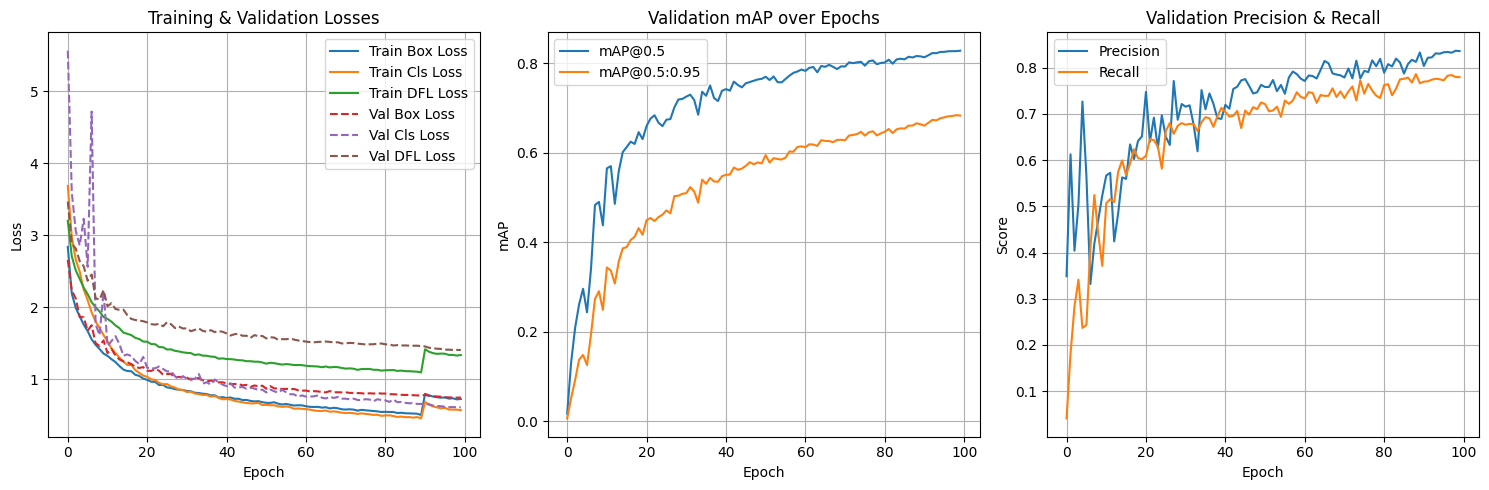

In [20]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the results CSV
results_path = "/kaggle/input/v8sresults/results.csv"
results_df = pd.read_csv(results_path)

# Plotting losses
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(results_df['train/box_loss'], label='Train Box Loss')
plt.plot(results_df['train/cls_loss'], label='Train Cls Loss')
plt.plot(results_df['train/dfl_loss'], label='Train DFL Loss')
plt.plot(results_df['val/box_loss'], '--', label='Val Box Loss')
plt.plot(results_df['val/cls_loss'], '--', label='Val Cls Loss')
plt.plot(results_df['val/dfl_loss'], '--', label='Val DFL Loss')
plt.title("Training & Validation Losses")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

# Plotting mAP@0.5 and mAP@0.5:0.95
plt.subplot(1, 3, 2)
plt.plot(results_df['metrics/mAP50(B)'], label='mAP@0.5')
plt.plot(results_df['metrics/mAP50-95(B)'], label='mAP@0.5:0.95')
plt.title("Validation mAP over Epochs")
plt.xlabel("Epoch")
plt.ylabel("mAP")
plt.legend()
plt.grid(True)

# Plotting precision and recall
plt.subplot(1, 3, 3)
plt.plot(results_df['metrics/precision(B)'], label='Precision')
plt.plot(results_df['metrics/recall(B)'], label='Recall')
plt.title("Validation Precision & Recall")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [26]:
results_test = model.val(
    data="/kaggle/input/datasetyaml-file/data (2).yaml",  # path to the YAML
    split='test',
    save=True,
    conf=0.25,
    iou=0.5,
    imgsz=640,
    project=save_dir,
    name="metrics"
)

print("✅ Test Evaluation Metrics:")
print("mAP@0.5:", results_test.box.map50)
print("mAP@0.5:0.95:", results_test.box.map)
print("Precision (mean):", results_test.box.mp)
print("Recall (mean):", results_test.box.mr)


Ultralytics 8.3.115 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 53.5±12.0 MB/s, size: 27.3 KB)


val: Scanning /kaggle/input/clc-xrayy/test/labels... 956 images, 0 backgrounds, 0 corrupt: 100%|██████████| 956/956 [00:01<00:00, 858.97it/s]

WARNING ⚠️ val: Cache directory /kaggle/input/clc-xrayy/test is not writeable, cache not saved.



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:18<00:00,  3.30it/s]


                   all        956       1421      0.727      0.611      0.677      0.569
                  Cans         37         47      0.648      0.255      0.378      0.349
          CartonDrinks         46         51       0.78      0.694      0.776      0.608
           GlassBottle         83        109      0.364      0.055       0.17      0.127
         PlasticBottle        488        590      0.732      0.671      0.705      0.589
             SprayCans         90        114      0.429     0.0877      0.172      0.123
        SwissArmyKnife         17         17      0.882      0.882      0.934      0.733
                   Tin         45         49      0.718      0.571       0.67       0.57
             VacuumCup        314        321      0.807      0.862      0.858      0.776
                 blade         27         34      0.635      0.735      0.727      0.544
                dagger         19         19      0.903      0.895      0.935      0.832
                 knif

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.4ms preprocess, 15.2ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to /kaggle/working/test_results/metrics5
✅ Test Evaluation Metrics:
mAP@0.5: 0.6766981448524336
mAP@0.5:0.95: 0.5693644564701991
Precision (mean): 0.72657178058248
Recall (mean): 0.6111300345348473
